# How to use scConnect to build and analyze a connectivity graph

scConnect integrate into a Scanpy analysis pipeline by utilizing the AnnData objects. This tutorial will not cover usage of scanpy, but tutorials for this can be found [here](https://scanpy.readthedocs.io/en/latest/tutorials.html).

We will cover four aspects:
* Gene calling
* Inference of interactions
* Construction of multi-directional graph
* Analysis of graph

However, before we begin, we will nend a dataset to work on. We will investigate the mouse brain dataset from [Saunder et al.](https://www.sciencedirect.com/science/article/pii/S0092867418309553). The original dataset contains hundreds of thousands of cells, but we will investigate meta cells (summation of all reads of cells from the same cell type) which drastically decrease the size of the dataset. 

All meta cells has two levels of annotations. the First level relates to the tissue from which the cell originates. These are:
* Hippocampus (HC)
* Thalamus (TH)
* Frontal cortex (FC)
* Striatum (STR)
* Globus Pallidus and nucleus basalis (GP)
* Entopeducular nucleus and subthalamic nucleus (ENT)
* Substantia nigra and ventral tegmental area (SN)
* Cerebellum (CB)
* Posterior cortex (PC)

the second level is the cell type annotation, such as *Fast-spiking interneuron, Pvalb+*

# loading the dataset
Lets begin by importing all the packages we will need. 

In [1]:
import pandas as pd
import scanpy as sc
import scConnect as cn
import matplotlib
import matplotlib.pyplot as plt

c:\users\jetja\appdata\local\conda\conda\envs\scconnect_test\lib\site-packages\scanpy\api\__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


We read in the meta cells using `sc.read_csv()` and add the metadata to adata.obs.

In [2]:
adata = sc.read_csv("data/metacells.BrainCellAtlas_Saunders_version_2018.04.01.csv").T
meta = pd.read_excel("data/annotation.BrainCellAtlas_Saunders_version_2018.04.01.xlsx", index_col="tissue_subcluster")
adata.obs = meta
adata.obs.head(10)

,tissue,class,class_marker,type_marker,full_name,common_name,subcluster
tissue_subcluster,,,,,,,
CB_1-1,CB,NEURON,Slc17a7,Gabra6,Neuron.Slc17a7.Gabra6,Granule cells,1-1
CB_10-1,CB,ENDOTHELIAL_STALK,Flt1,Mgp,Endothelial_Stalk.Flt1.Mgp,Endothelial_Stalk.Flt1.Mgp,10-1
CB_10-2,CB,ENDOTHELIAL_STALK,Flt1,Car4,Endothelial_Stalk.Flt1.Car4,Endothelial_Stalk.Flt1.Car4,10-2
CB_10-3,CB,ENDOTHELIAL_STALK,Flt1,Lrg1,Endothelial_Stalk.Flt1.Lrg1,Endothelial_Stalk.Flt1.Lrg1,10-3
CB_11-1,CB,ENDOTHELIAL_TIP,Dcn,Nnat,Endothelial_Tip.Dcn.Nnat,Endothelial_Tip.Dcn.Nnat,11-1
CB_11-2,CB,ENDOTHELIAL_TIP,Dcn,Apod,Endothelial_Tip.Dcn.Apod,Endothelial_Tip.Dcn.Apod,11-2
CB_11-3,CB,MURAL,Acta2Rgs5,Acta2,Mural.Acta2Rgs5.Acta2,Mural.Acta2Rgs5.Acta2,11-3
CB_11-4,CB,MURAL,Acta2Rgs5,Kcnj8,Mural.Acta2Rgs5.Kcnj8,Mural.Acta2Rgs5.Kcnj8,11-4
CB_11-5,CB,MURAL,Acta2Rgs5,Rgs5,Mural.Acta2Rgs5.Rgs5,Mural.Acta2Rgs5.Rgs5,11-5


Notice that we have cells of many different types. We will focus on neurons in our analysis, and hence we will only keep these meta cells.

In [3]:
adata = adata[adata.obs["class"] == "NEURON"]
adata

View of AnnData object with n_obs × n_vars = 324 × 32307
    obs: 'tissue', 'class', 'class_marker', 'type_marker', 'full_name', 'common_name', 'subcluster'

In many pipelines, we whould now normalize and logaritmize the read values to better visualize differences in gene expression. we will do the same here. 

*Note that scConnect will later transform all values back to reads. If we were to perform some more advanced transformations, we can specifically discribe this to correcly transform the read values.*

In [4]:
sc.pp.normalize_total(adata, exclude_highly_expressed=True)
sc.pp.log1p(adata)

c:\users\jetja\appdata\local\conda\conda\envs\scconnect_test\lib\site-packages\scanpy\preprocessing\_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


We now have everything that we need to proceed with scConnect: 
* AnnData object
* Cell type annotations in adata.obs

scConnect already come packaged with a database for the mouse genome, but if you want to analyse any other species you can set up a database using `cn.database.setup_database()` and provide the species name: *mmusculus* for Mouse, *hsapiens* for human etc.

You can further select which receptor types that you want to include in the database.

* enzyme
* transporter
* gpcr
* catalytic_receptor
* other_protein
* vgic
* lgic 
* other_ic
* nhr

Here we select receptors that are present at the synapses of neurons.

You can read more about receptor types [here](https://www.guidetopharmacology.org/targets.jsp).

Guide to Pharmacology (GTF) update their database regularly, and we include the latest database version available for each scConnect release. If you would like to update scConnect, and still use an older GTP database version, you can set this using `cn.database.version`.

**Note:** You will only have to run this once, as the files are changed in the package. If you run another pipeline with other database setting for the same species, you will have to rerun this database setup.

In [5]:
# set correct database ONLY RUN WHEN DATABASE HAS CHANGED
cn.database.version = "2019-5"
#cn.database.setup_database("mmusculus", receptor_types=["lgic", "vgic", "gpcr", "catalytic_receptor"])

# Gene calling
The gene/protein correlation is quite weak at a single cell level, however, at a cell type level (grouping cells by cell type) the correlation is much better. During gene celling, we achieve this by grouping all cells (in our case meta cells) by some cell annotation. 

For our purposes we will group all cells from each brain regoin (*tissue*) and assess the mean gene expression. This will produce a new matrix with *tissues* as columns and genes as rows.

At this stage, we will also describe how the counts/reads have been transformer in order to transform them back to counts/reads. We do this by providing `"log1p"` to the transformation argument. This argument also accepts a function that would transform the values correcly.

In [6]:
adata_tissue = cn.genecall.meanExpression(adata, groupby="tissue", normalization=False, use_raw=False, transformation="log1p")
adata_tissue.uns["gene_call"].head(10)

tissue,CB,ENT,FC,GP,HC,PC,SN,STR,TH
0610005C13Rik,1.206128,0.164717,0.088547,0.309107,0.126791,0.130319,0.424046,0.061124,0.143608
0610007P14Rik,70.244576,32.205215,26.356901,29.308931,33.681461,27.438030,25.901112,35.580597,29.833635
0610009B22Rik,48.714878,21.362782,22.037834,15.011244,31.001938,19.683691,17.582552,35.335930,19.150042
0610009E02Rik,0.886484,3.418047,0.892623,1.502334,1.057129,0.983461,1.826454,0.305784,1.150824
0610009L18Rik,5.448010,7.890305,3.755286,4.002081,6.330668,4.731245,4.280804,6.630234,3.887439
0610009O20Rik,10.788273,9.835737,9.653899,13.060631,9.339097,10.501668,10.973040,10.845959,9.275872
0610010F05Rik,33.398140,41.161461,56.321987,45.714489,44.228630,54.559231,51.293636,38.018227,62.149136
0610010K14Rik,0.775431,0.074247,0.463015,0.183771,0.154365,0.328687,0.124168,0.049013,0.074620
0610011F06Rik,51.467594,39.626549,27.967623,27.635063,34.014008,31.204346,37.187309,29.208063,41.085770
0610025J13Rik,0.014621,0.000000,0.010907,0.010785,0.022428,0.013433,0.013677,0.262045,0.000000


Next step is to connect gene expression to ligands and reecptors. We do this using `cn.connect.ligands()` and `cn.connect.receptors()`. The results are stored under `adata.uns["receptors"]` and `adata.und["ligands"]` respectivly.

In [7]:
adata_tissue = cn.connect.ligands(adata_tissue)
adata_tissue = cn.connect.receptors(adata_tissue)

pd.DataFrame(adata_tissue.uns["ligands"]).head(10)

FileNotFoundError: [Errno 2] File c:\users\jetja\appdata\local\conda\conda\envs\scconnect_test\lib\site-packages\scConnect\data\Gene_annotation\2019-5\mmusculus\ligands.csv does not exist: 'c:\\users\\jetja\\appdata\\local\\conda\\conda\\envs\\scconnect_test\\lib\\site-packages\\scConnect\\data\\Gene_annotation\\2019-5\\mmusculus\\ligands.csv'

# Constructing the graph
A graph is built up of two parts; edges and nodes. An edge describe a relationship between two nodes, and the edge can be directional, meaning that the described edge only is true in one direction. Here, we describe interactions (edges) between two tissues (nodes), and we base this by infering interactions between two tissue if they have a matching ligand-receptor pair, that we know can interact with each other. This information is fetched from GTF and was included when we ran the database setup earlier.

## Detecting edges
We can detect eges between two AnnData object that has ligands and receptor annotation in them. In our case, we whould like to detect edges between the tissues of ust one AnnData object. We can do this by passing the same adata as emmitor and as target to `cn.connect.interactions()`. This produce a list of all interaction between all tissues.

## Collecting metadata about the tissues
using `cn.connect.nodes()` we can collect all metadata about the different tissues, as we want to include this in our graph later on

In [10]:
edges = cn.connect.interactions(adata_tissue, adata_tissue, self_reference=True)
nodes = cn.connect.nodes(adata_tissue)

finding connections between 9 emitter clusters and 9 target clusters |██████████████████████████████| 100.0% 
precessing adata #1
processing cluster CB
processing cluster ENT
processing cluster FC
processing cluster GP
processing cluster HC
processing cluster PC
processing cluster SN
processing cluster STR
processing cluster TH


We can construct the graph by passing in the edge list and the node list to `cn.graph.build_graph()`. The result is a `networkX.MultiDiGraph`.

In [11]:
G_tissue = cn.graph.build_graph(edges, nodes)


Graph has 29768 interactions between 9 clusters
CB has 5018 interactions
ENT has 5366 interactions
FC has 7588 interactions
GP has 6723 interactions
HC has 7424 interactions
PC has 7257 interactions
SN has 6478 interactions
STR has 6912 interactions
TH has 6770 interactions


# Analysis of the graph
The data in the graph is complex, and several types of analysis might be suitable for different purposes. scConnect can run a Dash web application for interactive exploratory analysis of the graph, and it is recommended to initally use this method to get a feeling of the graph.

The web app is run by passing the graph object to `cn.app.graph()`. This will freeze the notebook while it is hosting the web app. Click on the link to open the application, and when you are done exploring, you can interrupt the kernel and continue the tutorial. 

In [22]:
cn.app.graph(G_tissue)

## web app
If you are not running this notebook on your own machine, here is a short description of the web app's functionallity.


### Network graph
In the  main network graph, you can select either a node or an edge. Here we have selected the SN population.
![network graph](assets/network_graph.png)

### Connectivity graph
Focusing on the SN population we will get a connectivity graph with all incomming and outgoing interactions the the SN population. Note that you can filter interactions based on scores so to only detect the strongest (score), or most specific (weighted score). Hovering over the interactions provide you with further details.
![connectivity graph](assets/connectivity_graph.png)

### Ligands and receptors
You can also investigate the ligand and receptors expressed by the population. Note that the plot is dynamic, and you can zoom in and pan around. Further more, you can search for specific receptors or ligands.
![ligands and receptors](assets/ligands_receptors_plot.png)


### Interactions
Selecting an edge in the main network graph provides a list of all interactions between the source and target node. This table can be sorted on score and weighted score and provide information about the ligand, receptor and receptor family in the interaction. 

![interactions](assets/interaction.png)

## Splitting the graph on interaction
By splitting the graph on interactions, we can assess the contribution of a specific ligand and receptor pair to the graph. This is especially usefull if you are interested in something perticular. We split the graph with `cn.graph.split_graph()` which returns a dictionary with interactions as keys and `networkX.DiGraph` as values.


In [13]:
Gs_tissue = cn.graph.split_graph(G_tissue)

We can visualize a `networkX.DiGraph` using the `cn.graph.plot_adjacency_matrix()`, and by utilizing the built in interaction module of jupyter notebooks, we can interactivly browse the different interacitons.

In [14]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def f(interaction):
    return cn.graph.plot_adjacency_matrix(Gs_tissue[interaction], weight="log_score", width=400, height=400, fontsize=15, fontscale=1.0)

options = list(Gs_tissue.keys())
options.sort()
interact(f, interaction=widgets.Dropdown(options=options, index=0))

interactive(children=(Dropdown(description='interaction', options=('(-)-adrenaline --> α1A-adrenoceptor', '(-)…

<function __main__.f(interaction)>

## Interaction differences
Sometimes you would like to compare the interactions that two populations are involved in. This could be between two treatment groups to assess how the connectivity changed. For our purposes, we will compare the interactions made by pariental cortex (PC) and frontal cordex (FC).

Using the threshold of 2, we will only plot interactions that is 2 times stronger in any of the populations.

Red values are stronger in node a (PC) and blue values are stronger in node b (FC). Color bar is log10(ratio)

**Note:** *Receptor familiy is plotted for each row, so this function prints out the receptor families used in order, and a corresponding color bar. This is for publishing reasons, as you might want to build this figure with these components seperatly. This might change in furure releases to produce publishable images direcly.*


incomming interactions
Outgoing interactions
receptor families in order: ['IL-6 receptor family', 'Neurotensin receptors', 'Melanocortin receptors', 'Tachykinin receptors', 'Neuropeptide W/neuropeptide B receptors', 'Neuropeptide Y receptors', 'Somatostatin receptors', 'Relaxin family peptide receptors', 'Type I RTKs: ErbB (epidermal growth factor) receptor family', 'Cholecystokinin receptors']


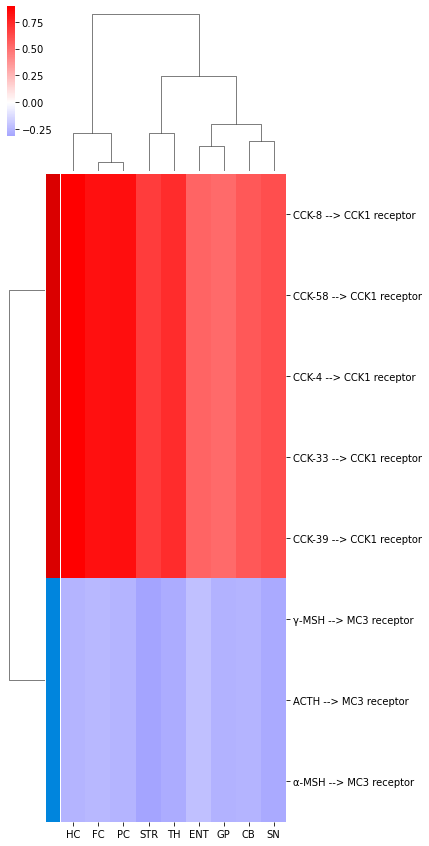

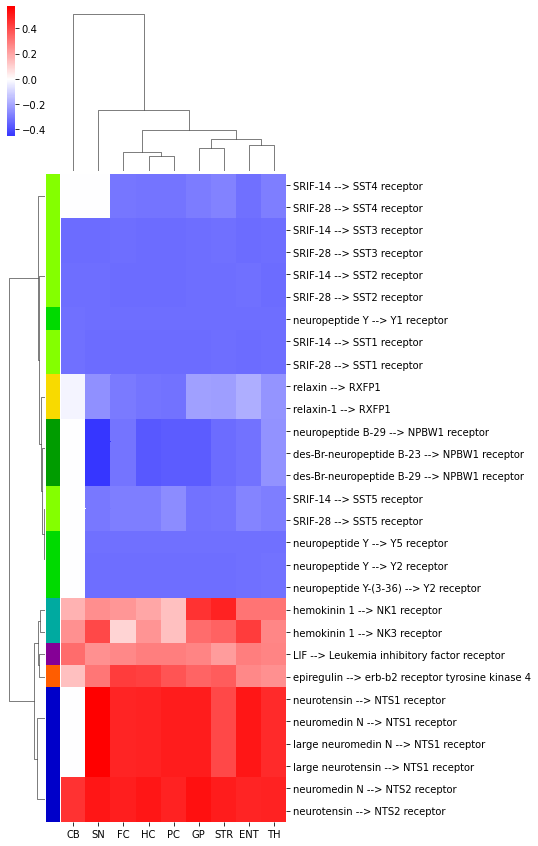

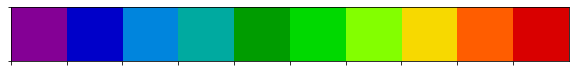

In [15]:
cn.graph.compare_interactions_plot(G_tissue, node_a="PC", node_b="FC", th=2)

## Manual access to data
Data is accessable directly from the MultiDiGraph and from the AnnData objects them self. Future releases will contain functions to simplify plotting of this information, such as the selected receptor and ligand plots bellow where the bar colors match the web app node colors.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

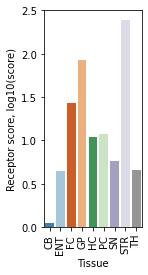

In [16]:
import numpy as np

import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.DataFrame(adata_tissue.uns["receptors"]).loc[["D1 receptor"]]


nodes = pd.Categorical(G_tissue.nodes())
# make a list of RGBA tuples, one for each node
colors = plt.cm.tab20c(nodes.codes/len(nodes.codes), bytes=False)
# zip node to color
color_map_nodes = dict(zip(nodes, colors))

f = sns.barplot(data=np.log10(df+1), palette=color_map_nodes)
f.set_xlabel("Tissue")
f.set_ylabel("Receptor score, log10(score)")
f.set_aspect(8, "box")
plt.xticks(rotation=90)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

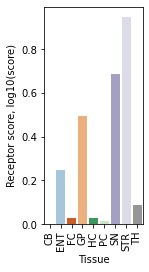

In [18]:
import numpy as np

import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.DataFrame(adata_tissue.uns["receptors"]).loc[["D2 receptor"]]


nodes = pd.Categorical(G_tissue.nodes())
# make a list of RGBA tuples, one for each node
colors = plt.cm.tab20c(nodes.codes/len(nodes.codes), bytes=False)
# zip node to color
color_map_nodes = dict(zip(nodes, colors))

f = sns.barplot(data=np.log10(df+1), palette=color_map_nodes)
f.set_xlabel("Tissue")
f.set_ylabel("Receptor score, log10(score)")
f.set_aspect(20, "box")
plt.xticks(rotation=90)


In [19]:
df = pd.DataFrame(adata_tissue.uns["ligands"]).loc[["dopamine"]]
np.log10(df+1)

,CB,ENT,FC,GP,HC,PC,SN,STR,TH
dopamine,0.0,0.768366,0.150231,0.727891,0.123196,0.041154,2.724125,0.513421,0.333747


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

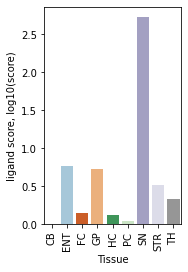

In [20]:
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.DataFrame(adata_tissue.uns["ligands"]).loc[["dopamine"]]
np.log10(df+1)

nodes = pd.Categorical(G_tissue.nodes())
# make a list of RGBA tuples, one for each node
colors = plt.cm.tab20c(nodes.codes/len(nodes.codes), bytes=False)
# zip node to color
color_map_nodes = dict(zip(nodes, colors))

f = sns.barplot(data=np.log10(df+1), palette=color_map_nodes)
f.set_xlabel("Tissue")
f.set_ylabel("ligand score, log10(score)")
f.set_aspect(5, "box")
plt.xticks(rotation=90)


# Further help
I hope this tutorial introduced you the the posibilities with scConnect. For further information please visit the projects [github](https://github.com/JonETJakobsson/scConnect) and [documentation](https://scconnect.readthedocs.io/en/latest/)